In [0]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
from scipy.stats import *
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns # informative statistical graphics.
import statsmodels.api as sm #for ARIMA and SARIMAX
import datetime
from datetime import timedelta


sns.set_style('darkgrid') #set color style for plot

In [67]:
#importing dataset for API

train = pd.read_csv('http://api.covid19india.org/states_daily_csv/confirmed.csv')

#DF = DF[:-1]
train = train[:-1]

train['date'] = pd.to_datetime(train['date'], format="%d-%b-%y")

train.head()

,date,TT,AN,AP,AR,AS,BR,CH,CT,DD,DL,DN,GA,GJ,HP,HR,JH,JK,KA,KL,LA,LD,MH,ML,MN,MP,MZ,NL,OR,PB,PY,RJ,SK,TG,TN,TR,UP,UT,WB,Unnamed: 39
0,2020-03-14,81,0,1,0,0,0,0,0,0,7,0,0,0,0,14,0,2,6,19,0,0,14,0,0,0.0,0,0,0,1,0,3,0,1,1,0,12,0,0,NaN
1,2020-03-15,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,18,0,0,0.0,0,0,0,0,0,1,0,2,0,0,1,0,0,NaN
2,2020-03-16,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0,6,0,0,NaN,0,0,1,0,1,0,0,1,0,0,0,1,0,NaN
3,2020-03-17,11,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,0,0,0,3,0,0,0.0,0,0,0,0,0,0,0,1,0,0,2,0,1,NaN
4,2020-03-18,37,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,1,5,0,8,0,3,0,0,0.0,0,0,1,1,0,3,0,8,1,0,2,1,0,NaN


In [0]:
#Since we are predicting total cases ('TT') column we don't need state data ,  hence droping out state data

cols = ['AN','AP',	'AR',	'AS',	'BR',	'CH',	'CT',	'DD',	'DL',	'DN',	'GA',	'GJ',	'HP',	'HR',	'JH', 'JK',	'KA',	'KL',	'LA',	'LD',	'MH',	'ML',	'MN',	'MP',	'MZ',	'NL',	'OR',	'PB',	'PY',	'RJ',	'SK',	'TG',	'TN',	'TR',	'UP',	'UT',	'WB']
train.drop(cols, axis=1, inplace=True)

In [69]:
train.head()

,date,TT,Unnamed: 39
0,2020-03-14,81,NaN
1,2020-03-15,27,NaN
2,2020-03-16,15,NaN
3,2020-03-17,11,NaN
4,2020-03-18,37,NaN


In [70]:
# # copying data into train_df Dataframe so that our orignal data is untouched 

train_df = train

train_df.head()

,date,TT,Unnamed: 39
0,2020-03-14,81,NaN
1,2020-03-15,27,NaN
2,2020-03-16,15,NaN
3,2020-03-17,11,NaN
4,2020-03-18,37,NaN


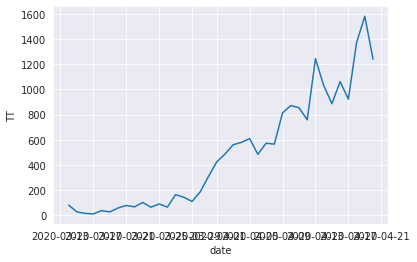

In [71]:
#plotting current data

sns.lineplot(x="date", y="TT",legend = 'full' , data=train_df)

In [72]:
#setting 'date' column as index columna as forecasting will be done for this column
#making 'TT' as float for statistical calculations

train_df = train_df.set_index('date')
train_df['TT'] = train_df['TT'].astype(float)

train_df.head()

,TT,Unnamed: 39
date,,
2020-03-14,81.0,NaN
2020-03-15,27.0,NaN
2020-03-16,15.0,NaN
2020-03-17,11.0,NaN
2020-03-18,37.0,NaN


<Figure size 432x288 with 0 Axes>

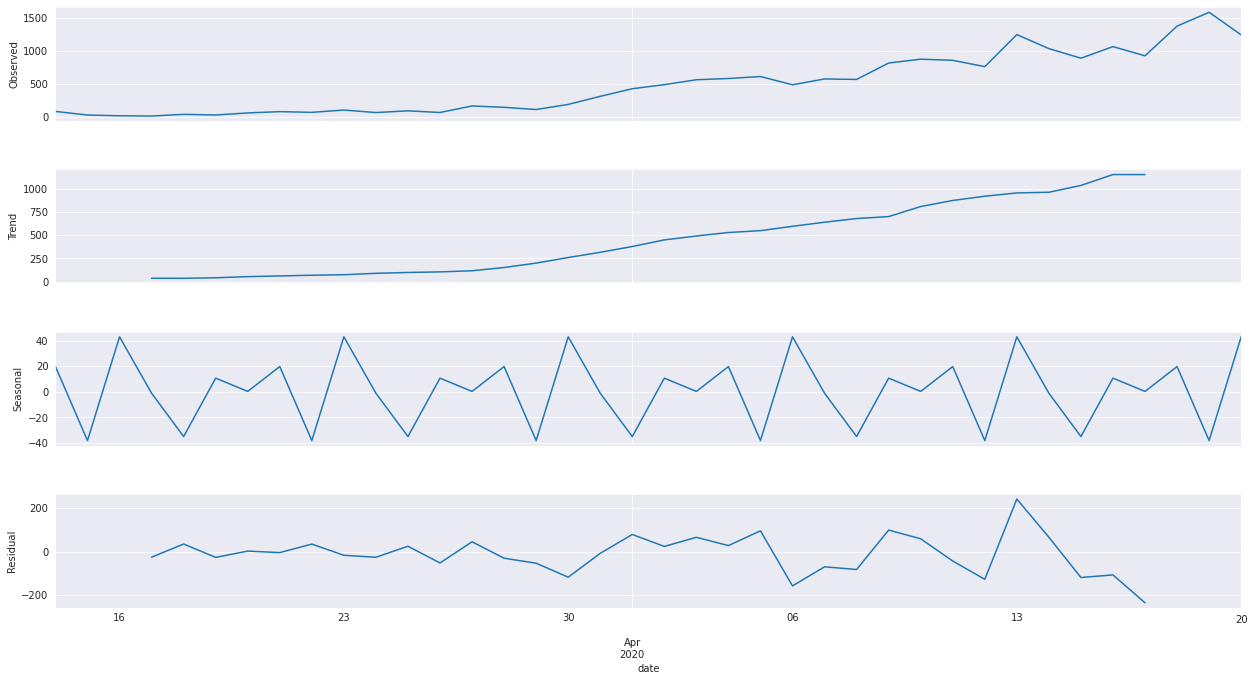

In [73]:
#Decomposing data to observe if there exists a sesional trend

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['TT'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)

The 'trend' graph has a upward growth which shows that the data is not stationary. Time Series forecasting can be done on stationary data and hence we need to nake it stationary.

In [0]:
from statsmodels.tsa.stattools import adfuller #adfuller stands for Augmented Dickey-Fuller unit root test.

#The function find mean and standard deviation of the series and and performs augmented dickey fuller test.
#returns pvale .. The samaller the pvalue more stationary is the series.

def test_stationarity(timeseries, window = 15, cutoff = 0.01):
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC',)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  pvalue = dftest[1]
  if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  
  print(dfoutput)

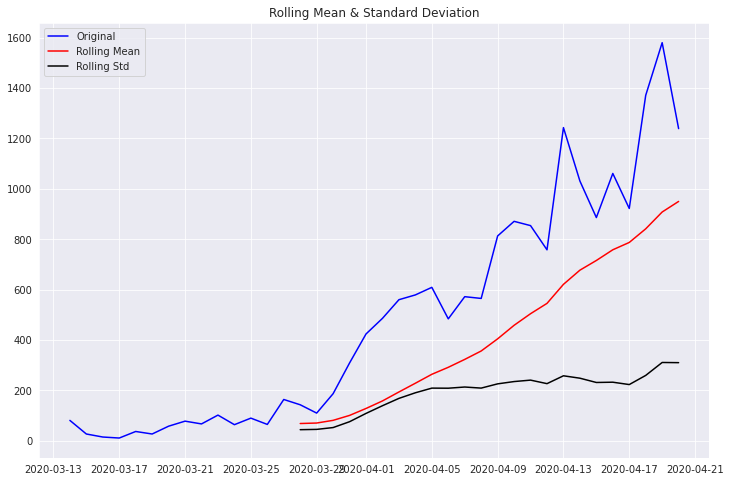

Results of Dickey-Fuller Test:
p-value = 0.9925. The series is likely non-stationary.
Test Statistic                  0.858882
p-value                         0.992530
#Lags Used                      9.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


In [75]:
test_stationarity(train_df['TT'])

#calling the function gives below result , where we can observe the huge gap between orignal data and mean,std
#also the pvalue is 0.9778 which is not so good and hence , the output says "The series is likely non-stationary."

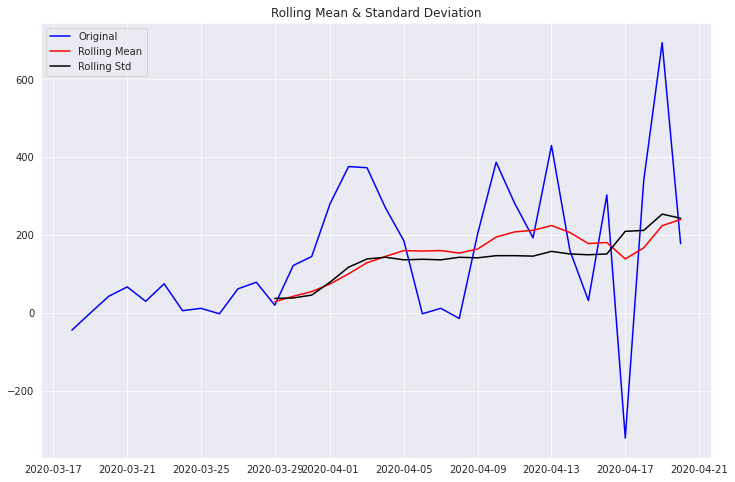

Results of Dickey-Fuller Test:
p-value = 0.5214. The series is likely non-stationary.
Test Statistic                 -1.524329
p-value                         0.521443
#Lags Used                      4.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [76]:
#here are various methods for making series stationary like log, differencing and so on..
#here we are using differencing , shift operator shifts the 'TT' cloumn of df by 4 places and difference is taken.

#plotting the data after differencing we see the pvalue is reduced to 0.3427 which is quite good as compared to our previous value 0.9778
#you can try different values in shift to reduce the pvalue (if possible , #try to choose one where number of observations used is MAX abd pval is MIN)

first_diff = train_df.TT - train_df.TT.shift(4)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

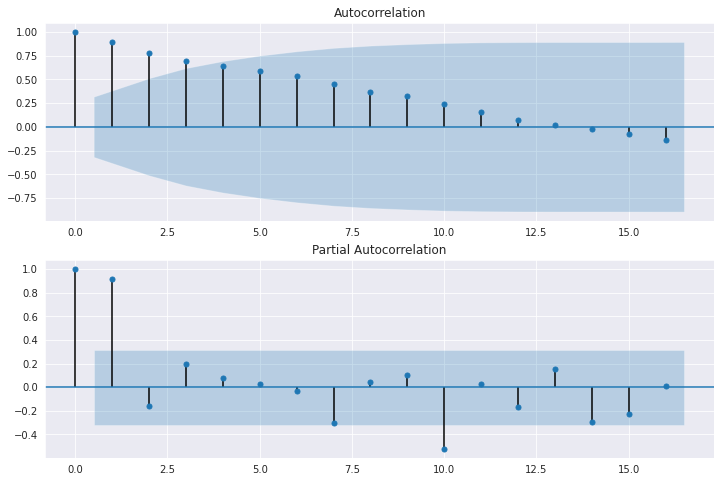

In [77]:
#plotting autocorrelation and partial autocorrelation for both data (data before differencing and data after differencing)

import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.TT, ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.TT, ax=ax2) # using default value of lag

Here in partial autocorrelation we can see a small upward trend for ( almost ) every second plot as compared to previous plot. 

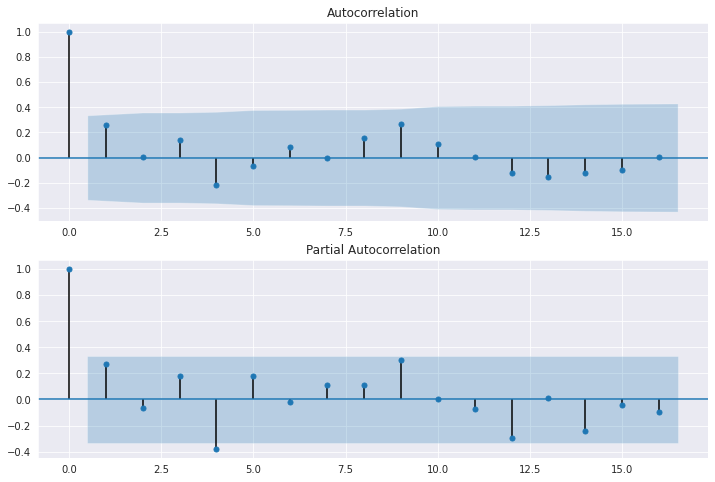

In [78]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)

In [79]:
# we can see a recurring correlation exists in both ACF and PACF hece we should choose SARIMAX model which also deals with seasonality

#RULE : A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that 
      #the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that 
      #the original series has a time-varying trend 

#Since our series has a contant average trend ( with growth ) we would take I = 1 and MA = 0 ( I-1 ).


sarimax_mod = sm.tsa.statespace.SARIMAX(train_df.TT, trend='n', order=(14,1,0)).fit()
print(sarimax_mod.summary())

                           Statespace Model Results                           
Dep. Variable:                     TT   No. Observations:                   38
Model:              SARIMAX(14, 1, 0)   Log Likelihood                -227.198
Date:                Tue, 21 Apr 2020   AIC                            484.396
Time:                        08:54:18   BIC                            508.560
Sample:                    03-14-2020   HQIC                           492.915
                         - 04-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3855      0.214     -1.802      0.072      -0.805       0.034
ar.L2         -0.2631      0.262     -1.005      0.315      -0.776       0.250
ar.L3          0.0217      0.310      0.070      0.9

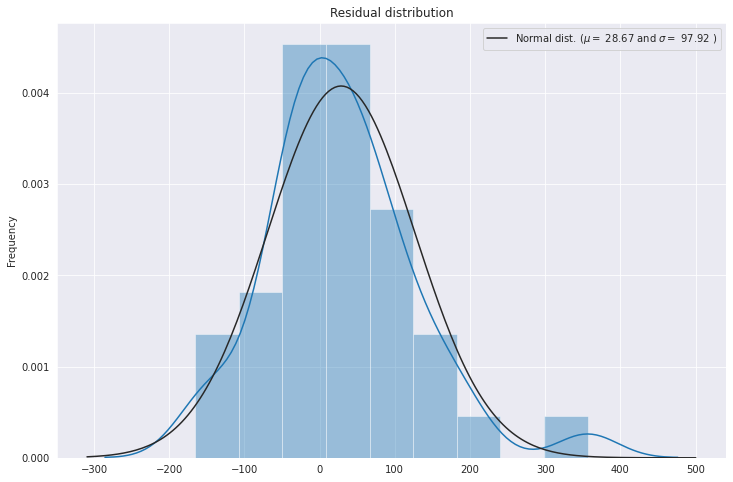

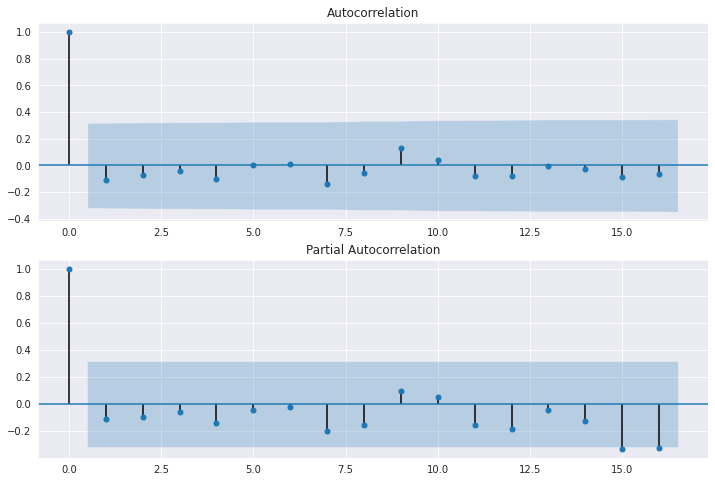

In [80]:
import scipy.stats as stats

resid = sarimax_mod.resid #gives residual degree of freedom (mu, sigma, pvalue ... )
#print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_mod.resid, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_mod.resid, ax=ax2)

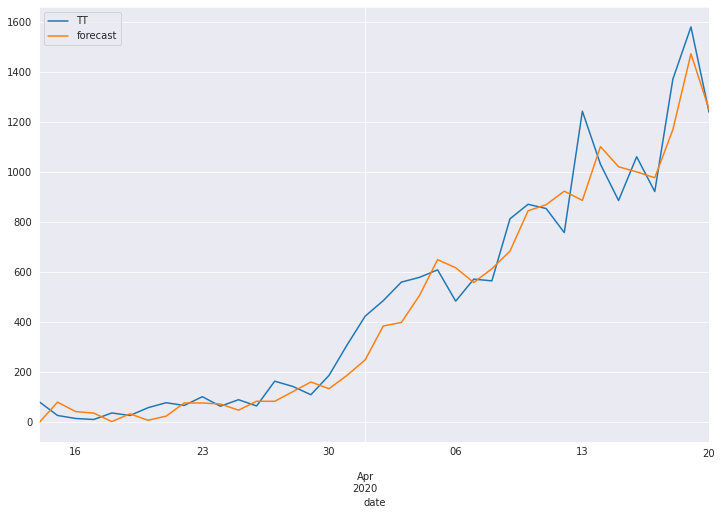

In [81]:
#Now lets predict using out model.

start_index = '14-Mar-20'
end_index = '27-Apr-20'

#adding forecasted values and plotting
train_df['forecast'] = sarimax_mod.predict(start= start_index,end = end_index,dynamic= False,)  

train_df[start_index:][['TT', 'forecast']].plot(figsize=(12, 8))

In [0]:
#lets predict for upcomming dates ..

future_predict = sarimax_mod.predict(start= datetime.date.today()-timedelta(days=1) ,end = datetime.date.today()+timedelta(days=7) ,dynamic= False,)

In [83]:
future_predict

2020-04-20    1250.323898
2020-04-21    1385.029504
2020-04-22    1689.087666
2020-04-23    1436.108914
2020-04-24    1679.087927
2020-04-25    1505.573266
2020-04-26    1483.685438
2020-04-27    1916.843635
2020-04-28    1916.319157
Freq: D, dtype: float64

In [0]:
# train_df=train_df.reset_index()
# train_df.head()

In [0]:
# dates=[]
# for i in future_predict.index:
#     if type(i)==type(future_predict.index[0]):
#       dates.append(i)
# data=[]
# for i in future_predict.values:
#   if type(i)==type(future_predict.values[0]):
#     data.append(i)

In [0]:
# train_df=train_df.reset_index()
# DF=pd.DataFrame({'forecast':data,'date':dates})
# train_df=train_df.append(DF)
# train_df=train_df.reset_index()
# train_df = train_df.set_index('date')
# train_df[start_index:][['TT', 'forecast']].plot(figsize=(12, 8))

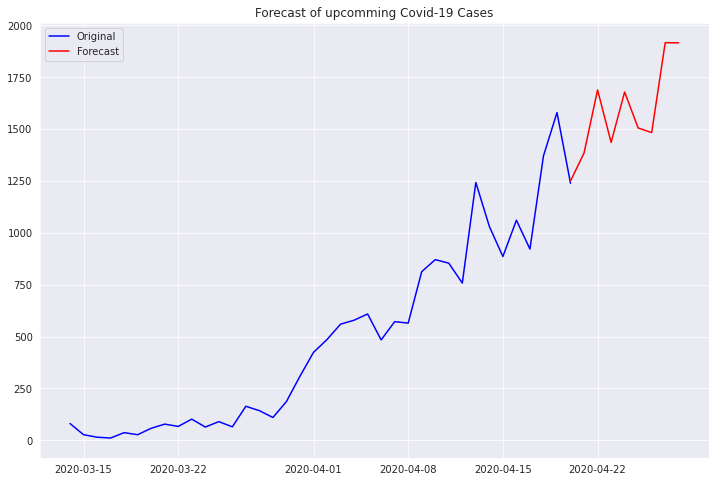

In [87]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(future_predict, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()